In [1]:
# ==============================
# Multi-Input, Multi-Task Model (Corrected)
# ==============================

# I. Setup
import os, glob
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Remove for GPU

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

print("TensorFlow version:", tf.__version__)


2025-08-25 15:08:12.843720: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-25 15:08:12.874988: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.20.0


In [2]:

# ==============================
# II. Image Data (BUSI dataset)
# ==============================
train_data = "Dataset_BUSI_with_GT"
image_size = (256, 256)
batch_size = 16

train_files = [i for i in glob.glob(train_data + "/*/*")]
labels = [os.path.dirname(i).split("/")[-1] for i in train_files]
training_data = pd.DataFrame({"Path": train_files, "Label": labels})

train_df, val_df = train_test_split(training_data, train_size=0.8, shuffle=True, random_state=123)

datagen = ImageDataGenerator(rescale=1.0/255)

train_img_gen = datagen.flow_from_dataframe(
    train_df, x_col="Path", y_col="Label",
    target_size=image_size, class_mode="categorical",
    shuffle=True, batch_size=batch_size
)
val_img_gen = datagen.flow_from_dataframe(
    val_df, x_col="Path", y_col="Label",
    target_size=image_size, class_mode="categorical",
    shuffle=False, batch_size=batch_size
)

num_img_classes = len(train_img_gen.class_indices)
print("Image classes:", train_img_gen.class_indices)
print("Number of image classes:", num_img_classes)


Found 1262 validated image filenames belonging to 3 classes.
Found 316 validated image filenames belonging to 3 classes.
Image classes: {'benign': 0, 'malignant': 1, 'normal': 2}
Number of image classes: 3
Found 316 validated image filenames belonging to 3 classes.
Image classes: {'benign': 0, 'malignant': 1, 'normal': 2}
Number of image classes: 3


In [3]:

# ==============================
# III. Tabular Data
# ==============================
dataset = load_breast_cancer()
X_tab, Y_tab = dataset.data, dataset.target

scaler = StandardScaler()
X_tab = scaler.fit_transform(X_tab)

X_tab_train, X_tab_val, Y_tab_train, Y_tab_val = train_test_split(
    X_tab, Y_tab, test_size=0.2, random_state=42
)
num_tab_features = X_tab.shape[1]


In [4]:

# ==============================
# IV. Build Multi-Task Model
# ==============================
def build_multitask_model():
    # Image branch
    image_input = Input(shape=(256, 256, 3), name='image_input')
    base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=image_input)
    for layer in base_model.layers:
        layer.trainable = False  # freeze CNN backbone

    x_img = GlobalAveragePooling2D()(base_model.output)
    x_img = Dense(512, activation='relu', name="img_dense1")(x_img)
    x_img = Dropout(0.5)(x_img)
    img_output = Dense(num_img_classes, activation='softmax', name='img_output')(x_img)

    # Tabular branch
    tab_input = Input(shape=(num_tab_features,), name='tabular_input')
    x_tab = Dense(64, activation='relu', name="txt_dense1")(tab_input)
    x_tab = Dropout(0.3)(x_tab)
    x_tab = Dense(32, activation='relu', name="txt_dense2")(x_tab)
    txt_output = Dense(1, activation='sigmoid', name='txt_output')(x_tab)

    model = Model(inputs=[image_input, tab_input], outputs=[img_output, txt_output])
    return model

multi_model = build_multitask_model()
multi_model.summary()


2025-08-25 15:08:14.103554: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-08-25 15:08:14.103575: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:160] env: CUDA_VISIBLE_DEVICES="-1"
2025-08-25 15:08:14.103579: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] CUDA_VISIBLE_DEVICES is set to -1 - this hides all GPUs from CUDA
2025-08-25 15:08:14.103581: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:171] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-08-25 15:08:14.103584: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:176] retrieving CUDA diagnostic information for host: sdu-133749
2025-08-25 15:08:14.103585: I external/local_xla/xla/stream_executor/cuda/cu

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 262, 262,  │          0 │ image_input[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 64, 64,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 64, 64,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 64, 64,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 64, 64,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 64, 64,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 64, 64,    │     12,288 │ conv2_block2_0_r

 Total params: 7,567,940 (28.87 MB)

 Trainable params: 530,436 (2.02 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [5]:

# ==============================
# V. Compile Functions
# ==============================
def compile_for_image(model):
    for layer in model.layers:
        if "txt_" in layer.name or layer.name=="txt_output":
            layer.trainable = False
        if "img_" in layer.name or layer.name=="img_output":
            layer.trainable = True

    model.compile(
        optimizer="adam",
        loss={
            "img_output": "categorical_crossentropy",
            "txt_output": "binary_crossentropy"  # dummy, won't affect training
        },
        loss_weights={
            "img_output": 1.0,
            "txt_output": 0.0
        },
        metrics={"img_output": "accuracy"}
    )
    return model

def compile_for_text(model):
    for layer in model.layers:
        if "img_" in layer.name or layer.name=="img_output":
            layer.trainable = False
        if "txt_" in layer.name or layer.name=="txt_output":
            layer.trainable = True

    model.compile(
        optimizer="adam",
        loss={
            "img_output": "categorical_crossentropy",
            "txt_output": "binary_crossentropy"
        },
        loss_weights={
            "img_output": 0.0,
            "txt_output": 1.0
        },
        metrics={"txt_output": "accuracy"}
    )
    return model


In [6]:

# ==============================
# VI. Train Textual Branch
# ==============================
multi_model = compile_for_text(multi_model)
history_txt = multi_model.fit(
    {"tabular_input": X_tab_train, "image_input": np.zeros((len(X_tab_train),256,256,3))},
    {"txt_output": Y_tab_train, "img_output": np.zeros((len(X_tab_train), num_img_classes))},
    validation_data=(
        {"tabular_input": X_tab_val, "image_input": np.zeros((len(X_tab_val),256,256,3))},
        {"txt_output": Y_tab_val, "img_output": np.zeros((len(X_tab_val), num_img_classes))}
    ),
    epochs=5,
    batch_size=8
)

# Evaluate textual
y_pred_txt = (multi_model.predict({"tabular_input": X_tab_val, 
                                   "image_input": np.zeros((len(X_tab_val),256,256,3))})[1] > 0.5).astype(int)
print(classification_report(Y_tab_val, y_pred_txt))


Epoch 1/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 16s 195ms/step - img_output_loss: 0.0000e+00 - loss: 0.3999 - txt_output_accuracy: 0.8681 - txt_output_loss: 0.3993 - val_img_output_loss: 0.0000e+00 - val_loss: 0.1578 - val_txt_output_accuracy: 0.9649 - val_txt_output_loss: 0.1575
Epoch 2/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 16s 195ms/step - img_output_loss: 0.0000e+00 - loss: 0.3999 - txt_output_accuracy: 0.8681 - txt_output_loss: 0.3993 - val_img_output_loss: 0.0000e+00 - val_loss: 0.1578 - val_txt_output_accuracy: 0.9649 - val_txt_output_loss: 0.1575
Epoch 2/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - img_output_loss: 0.0000e+00 - loss: 0.1479 - txt_output_accuracy: 0.9582 - txt_output_loss: 0.1479 - val_img_output_loss: 0.0000e+00 - val_loss: 0.0797 - val_txt_output_accuracy: 0.9825 - val_txt_output_loss: 0.0841
Epoch 3/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - img_output_loss: 0.0000e+00 - loss: 0.1479 - txt_output_accuracy: 0.9582 - txt_output_loss: 0.1479 - val_img_output_loss: 0.0000e+00 - val

In [7]:

# ==============================
# VII. Train Image Branch
# ==============================
multi_model = compile_for_image(multi_model)

# Generator with dummy tabular input
def generator_with_dummy_tab(img_gen, num_tab_features):
    while True:
        X_img, Y_img = next(img_gen)
        X_tab_dummy = np.zeros((X_img.shape[0], num_tab_features))
        Y_txt_dummy = np.zeros((X_img.shape[0], 1))
        yield {"image_input": X_img, "tabular_input": X_tab_dummy}, {"img_output": Y_img, "txt_output": Y_txt_dummy}

train_gen = generator_with_dummy_tab(train_img_gen, num_tab_features)
val_gen = generator_with_dummy_tab(val_img_gen, num_tab_features)

history_img = multi_model.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=len(train_img_gen),
    validation_steps=len(val_img_gen),
    epochs=10
)


Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - img_output_accuracy: 0.7488 - img_output_loss: 0.5795 - loss: 0.5798 - txt_output_loss: 0.9515 - val_img_output_accuracy: 0.8259 - val_img_output_loss: 0.3872 - val_loss: 0.3883 - val_txt_output_loss: 0.9570
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - img_output_accuracy: 0.7488 - img_output_loss: 0.5795 - loss: 0.5798 - txt_output_loss: 0.9515 - val_img_output_accuracy: 0.8259 - val_img_output_loss: 0.3872 - val_loss: 0.3883 - val_txt_output_loss: 0.9570
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 344ms/step - img_output_accuracy: 0.8391 - img_output_loss: 0.3896 - loss: 0.3898 - txt_output_loss: 0.9541 - val_img_output_accuracy: 0.8344 - val_img_output_loss: 0.3747 - val_loss: 0.3747 - val_txt_output_loss: 0.9570
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 344ms/step - img_output_accuracy: 0.8391 - img_output_loss: 0.3896 - loss: 0.3898 - txt_output_loss: 0.9541 - val_img_output_accuracy: 0.8344 - val_img_output_loss: 0.37

10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 714ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 714ms/step
              precision    recall  f1-score   support

      benign       0.90      0.91      0.91       187
   malignant       0.97      0.73      0.83        78
      normal       0.70      0.92      0.80        51

    accuracy                           0.87       316
   macro avg       0.86      0.86      0.85       316
weighted avg       0.88      0.87      0.87       316

              precision    recall  f1-score   support

      benign       0.90      0.91      0.91       187
   malignant       0.97      0.73      0.83        78
      normal       0.70      0.92      0.80        51

    accuracy                           0.87       316
   macro avg       0.86      0.86      0.85       316
weighted avg       0.88      0.87      0.87       316



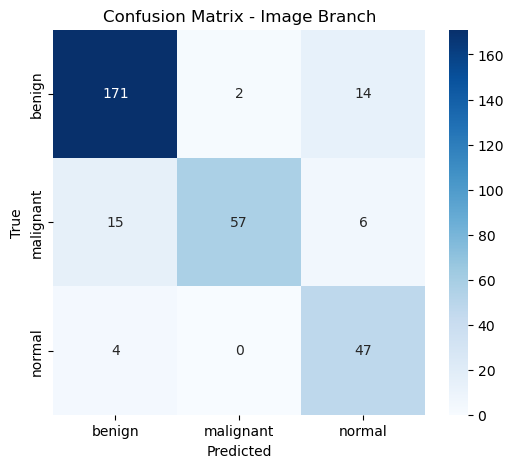

In [8]:

# ==============================
# VIII. Evaluate Image Branch
# ==============================
val_img_gen.reset()
X_imgs, Y_imgs = [], []
for batch in val_img_gen:
    X_imgs.append(batch[0])
    Y_imgs.append(batch[1])
    if len(X_imgs) * batch_size >= val_img_gen.n:
        break

X_imgs = np.concatenate(X_imgs, axis=0)
Y_imgs = np.concatenate(Y_imgs, axis=0)
y_pred_img = np.argmax(multi_model.predict({"image_input": X_imgs, 
                                            "tabular_input": np.zeros((len(X_imgs), num_tab_features))})[0], axis=1)
y_true_img = np.argmax(Y_imgs, axis=1)

print(classification_report(y_true_img, y_pred_img, target_names=list(train_img_gen.class_indices.keys())))

# Confusion matrix plot
cm = confusion_matrix(y_true_img, y_pred_img)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(train_img_gen.class_indices.keys()), yticklabels=list(train_img_gen.class_indices.keys()))
plt.title("Confusion Matrix - Image Branch")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


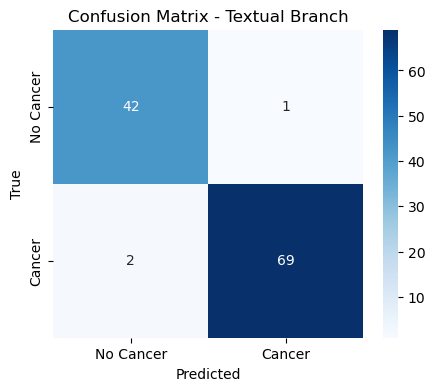

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix for textual branch
cm_txt = confusion_matrix(Y_tab_val, y_pred_txt)

# Plot
plt.figure(figsize=(5,4))
sns.heatmap(cm_txt, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["No Cancer", "Cancer"], 
            yticklabels=["No Cancer", "Cancer"])
plt.title("Confusion Matrix - Textual Branch")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
